Code by: **Fiona Chow and Jennah Gosciak**
* We are auditing the ADS with a public GitHub repo is here: https://github.com/jennahgosciak/algaebloom
* The original GitHub repository associated with this competition is here: https://github.com/apwheele/algaebloom

**Install and Load Libraries/Files**

In [58]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
os.getcwd()
os.chdir('/Users/fionachow/Documents/NYU/CDS/Spring 2023/1017 - Responsible Data Science/Project/algaebloom')
# os.chdir('C:/Users/Jennah/Desktop/Code/rds_project/algaebloom')
import geopandas as gpd
from census import Census
from us import states
import numpy as np
from tabulate import tabulate

In [60]:
satellite_data = pd.read_csv('./data/sat.csv')
elevation_data = pd.read_csv('./data/elevation_dem.csv')
metadata = pd.read_csv('./data/metadata.csv')

train = pd.read_csv('./data/train_labels.csv')
test = pd.read_csv('./data/test_labels.csv')
algae_acs = pd.read_csv('./data/algae_pts_with_tracts.csv')
spat_lag = pd.read_csv('./data/spat_lag.csv')
split_pred = pd.read_csv('./data/split_pred.csv')
submission_fmt = pd.read_csv('./data/submission_format.csv')

# Code for Input/Output Section
* Includes EDA on all input datasets and code for generating figures

**EDA for Metadata**

In [61]:
#count of training labels
train_count = metadata[metadata['split'] == 'train']['split'].value_counts()
#count of test labels
test_count = metadata[metadata['split'] == 'test']['split'].value_counts()

print(train_count)
print("----------")
print(test_count)

train    3000
Name: split, dtype: int64
----------
test    1167
Name: split, dtype: int64


In [62]:
#metadata types
metadata_train = metadata.loc[metadata['split']=='train']
metadata_train.dtypes

uid           object
latitude     float64
longitude    float64
date          object
split         object
dtype: object

/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_13992/3514872982.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train['date_fmt'] = pd.to_datetime(metadata_train['date'])


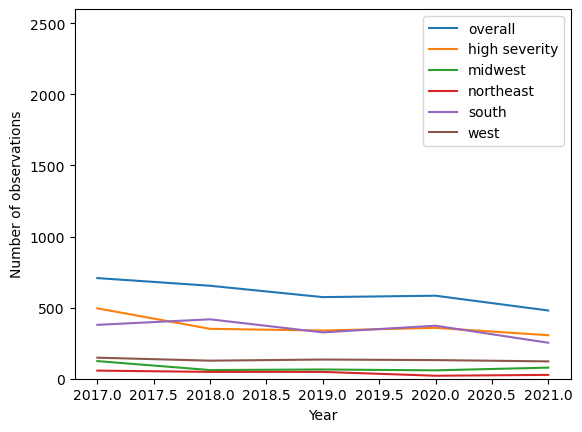

In [63]:
#Figure 1: Number of training data observations by year

train['severity_bin'] = np.where(train['density'] >= 20000, 'high', 'low')
metadata_train['date_fmt'] = pd.to_datetime(metadata_train['date'])
metadata_train_plot_df = pd.merge(train, metadata_train, on = "uid")
train['severity_bin'].value_counts(normalize=True)
metadata_train_plot_df['region'].unique()

metadata_train_plot_df['date_fmt'].dt.year.value_counts().sort_index().plot(
    rot=45, label = 'overall'
)
metadata_train_plot_df.loc[metadata_train_plot_df['severity_bin'] == 'high',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'high severity'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'midwest',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'midwest'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'northeast',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'northeast'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'south',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'south'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'west',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'west'
)
plt.ylim(0,2600)
plt.ylabel('Number of observations')
plt.xlabel('Year')
plt.legend()
plt.show();

**EDA for Training Data**

Notes from DrivenData:
* severity (int): severity level based on the cyanobacteria density
* density (float): raw measurement of total cyanobacteria density in cells per mL. Participants should submit predictions for severity level, NOT for the raw cell density value in cells per milliliter (mL). See the Submission format section.


Train columns: ['uid' 'region' 'severity' 'density' 'severity_bin']


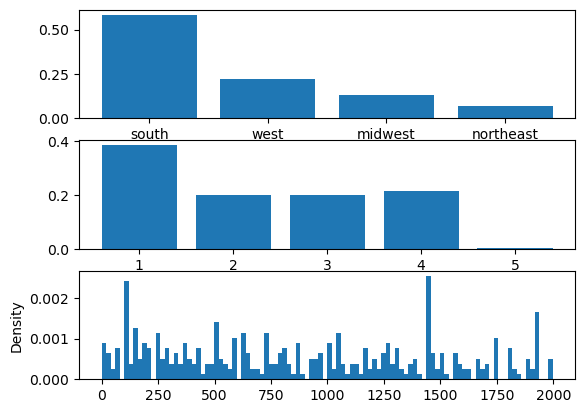

In [64]:
#Figure 2: Value distributions of input features from training labels
print("Train columns:", train.columns.values)
fig, axs = plt.subplots(3,1)
axs[0].bar(train['region'].value_counts(normalize=True).index,
           train['region'].value_counts(normalize=True))
axs[1].bar(train['severity'].value_counts(normalize=True).index,
            train['severity'].value_counts(normalize=True))
axs[2].hist(train.loc[train['density'] < 2000, 'density'], bins=100, density=True)
plt.ylabel('Density')
plt.show()

In [65]:
#training data types
train.dtypes

uid              object
region           object
severity          int64
density         float64
severity_bin     object
dtype: object

**EDA for Elevation Data**

In [66]:
#elevation data types
elevation_filt = elevation_data.loc[elevation_data['uid'].isin(train['uid'])]
elevation_filt.dtypes

latitude     float64
longitude    float64
box            int64
elevation    float64
mine         float64
maxe         float64
dife         float64
avge         float64
stde         float64
uid           object
DateTime      object
dtype: object

In [67]:
#elevation data info
elevation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   23570 non-null  float64
 1   longitude  23570 non-null  float64
 2   box        23570 non-null  int64  
 3   elevation  23570 non-null  float64
 4   mine       23570 non-null  float64
 5   maxe       23570 non-null  float64
 6   dife       23570 non-null  float64
 7   avge       23570 non-null  float64
 8   stde       23570 non-null  float64
 9   uid        23570 non-null  object 
 10  DateTime   23570 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB


In [68]:
#finding missing values by filtering for -99999 values as he documented using dife = -99999 for missing elevation data
elevation_data_describe = elevation_data[elevation_data['dife']== -99999].any(axis=1)

elevation_data_describe.describe()

count       0
unique      0
top       NaN
freq      NaN
dtype: object

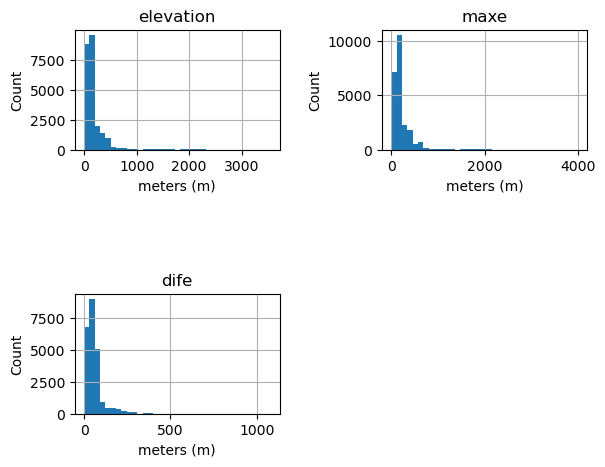

In [69]:
#Figure 3 - Plotting value distributions of input features for elevation data

elevation_data_input_features = elevation_data.drop(columns=['latitude', 'longitude', 'box', 'avge', 'stde', 'mine'])
hist_info = elevation_data_input_features.hist(bins=35)

plt.xlim(0, 1000)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=1.2)

# Iterate through the axes and set labels
for ax in hist_info.flatten():
    ax.set_ylabel('Count')
    ax.set_xlabel('meters (m)')

plt.show()

In [70]:
#elevation data statistics
elevation_data.describe()

,latitude,longitude,box,elevation,mine,maxe,dife,avge,stde
count,23570.000000,23570.000000,23570.0,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000
mean,37.599112,-91.438307,1000.0,175.416188,159.612456,218.089806,58.477350,182.174718,11.890973
std,2.823860,17.886877,0.0,273.668598,269.082678,296.131317,55.980386,278.927905,13.567918
min,26.389430,-124.179200,1000.0,-6.573961,-8.489909,0.000000,0.000000,-5.039981,0.000000
25%,35.700925,-109.370945,1000.0,56.113747,45.532188,97.374672,23.930344,65.147533,4.125027
50%,36.228150,-79.268000,1000.0,124.059055,98.498672,162.546829,51.229195,127.206436,9.250443
75%,38.930270,-79.026108,1000.0,180.500000,173.500000,229.550110,68.817337,184.266804,13.593365
max,48.973250,-67.698650,1000.0,3547.000000,3365.940430,3988.470703,1078.071045,3618.695068,213.942810


/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_13992/2425464916.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  elevation_correlation = elevation_data_input_features.corr()


<Axes: >

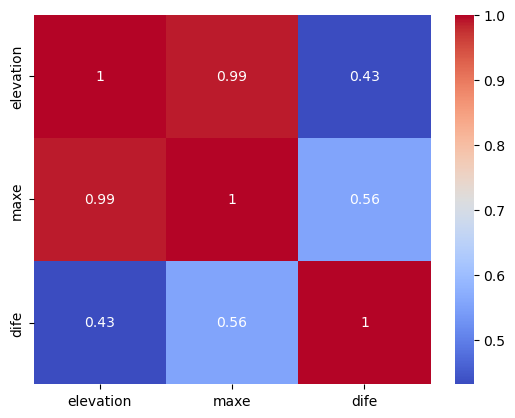

In [71]:
#Figure 4 - Elevation data correlation
elevation_correlation = elevation_data_input_features.corr()
sns.heatmap(elevation_correlation,annot=True, cmap='coolwarm')

**EDA for Satellite Data**

In [72]:
#satellite data statistics
satellite_filt = satellite_data.loc[satellite_data['uid'].isin(train['uid']) | 
                                    satellite_data['uid'].isin(test['uid'])]
satellite_filt.describe()

,prop_lake_500,r_500,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500
count,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000
mean,0.290154,127.809781,116.501116,89.103550,0.278580,131.758920,118.601446,90.949455,0.268171,134.995212,120.171041,92.775850
std,0.188427,56.016938,47.162234,46.319377,0.184434,52.330402,44.421790,44.563824,0.166606,48.764293,41.803439,43.317639
min,0.001456,1.000000,1.000000,1.000000,0.000335,1.000000,1.000000,1.000000,0.000248,1.000000,1.000000,1.000000
25%,0.137808,84.031873,82.032649,55.944079,0.139839,88.680403,86.802002,59.398676,0.138985,95.530093,91.051068,62.976869
50%,0.255161,124.516930,113.030488,83.103250,0.236383,132.596494,116.474663,84.968225,0.240796,136.472131,117.962559,86.438008
75%,0.414082,169.916667,142.700000,108.095238,0.387603,172.130292,144.000402,110.294123,0.374461,171.179788,143.244822,109.397648
max,1.000000,255.000000,255.000000,255.000000,1.000000,255.000000,255.000000,255.000000,1.000000,255.000000,247.808472,255.000000


In [73]:
#satellite data types and data info
satellite_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   imtype          9353 non-null   object 
 1   prop_lake_500   9353 non-null   float64
 2   r_500           9353 non-null   float64
 3   g_500           9353 non-null   float64
 4   b_500           9353 non-null   float64
 5   prop_lake_1000  9353 non-null   float64
 6   r_1000          9353 non-null   float64
 7   g_1000          9353 non-null   float64
 8   b_1000          9353 non-null   float64
 9   prop_lake_2500  9353 non-null   float64
 10  r_2500          9353 non-null   float64
 11  g_2500          9353 non-null   float64
 12  b_2500          9353 non-null   float64
 13  uid             9353 non-null   object 
 14  DateTime        9353 non-null   object 
dtypes: float64(12), object(3)
memory usage: 1.1+ MB


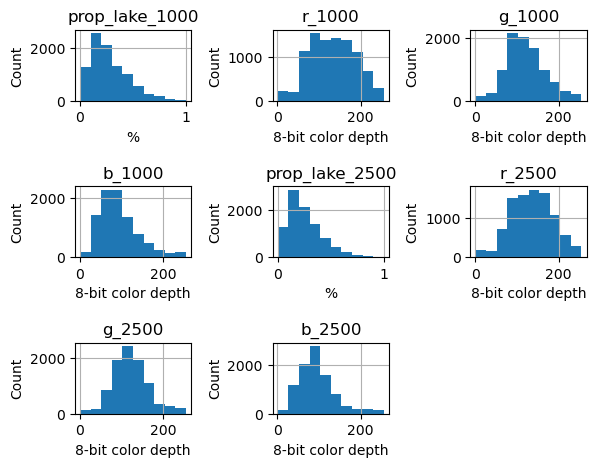

In [74]:
#Figure 5 - Plotting value distributions of input features for satellite data
satellite_data_input_features = satellite_data.drop(columns = ['prop_lake_500','r_500','g_500','b_500'])
numerical_columns_df = satellite_data_input_features.select_dtypes(include=['number'])
hist_info = numerical_columns_df.hist()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.7, hspace=1.2)

 # Iterate through the axes and set labels
for ax, col in zip(hist_info.flatten(), numerical_columns_df.columns):
    ax.set_ylabel('Count')
    if col in ['prop_lake_1000', 'prop_lake_2500']:
        ax.set_xlabel('%')
    else:
        ax.set_xlabel('8-bit color depth')

In [75]:
#finding missing values by filtering for -1 values as he documented using .fillna(-1) for missing satelite data
satellite_data[(satellite_data==-1).any(axis=1)]

,imtype,prop_lake_500,r_500,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500,uid,DateTime


/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_13992/1807249570.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sat_correlation = satellite_data_input_features.corr()


<Axes: >

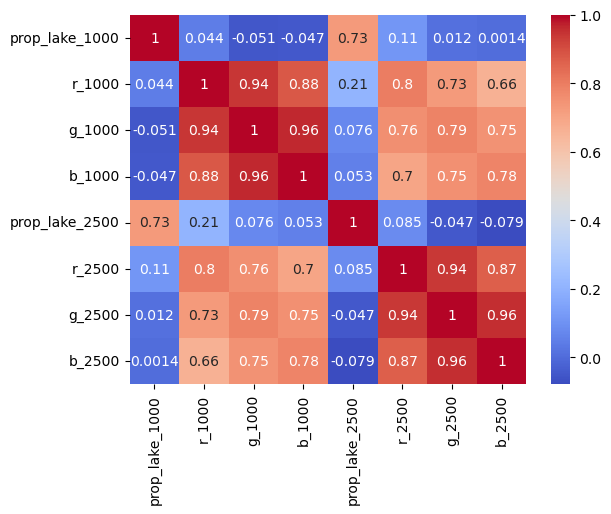

In [76]:
#Figure 6: Correlation of input features from satellite images
sat_correlation = satellite_data_input_features.corr()
sns.heatmap(sat_correlation, annot=True, cmap='coolwarm')

**EDA for Output Data**

**Important note from DrivenData:** "Each geographic area is either entirely in the train set or entirely in the test set. This means that none of the test set locations are in the training data, so your model's performance will be measured on unseen locations."

What should we consider to be severe?
* From this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4014740/#:~:text=In%20particular%2C%20Cyanobacteria%20may%20be,water%20and%20decreases%20its%20transparency): "At times, the phenomenon is so obvious, that the naked eye can see the mass of microscopic algae, which produce blooms giving a particular coloring to the water body. The term “algal blooms” indicates a situation in which 80%–90% of the mass of microscopic algae consists of one or two species. In particular, Cyanobacteria may be considered as blooming when their cell number exceeds one million per liter. This coating of microscopic algae covers the surface of the water and decreases its transparency. This, in turn, prevents the penetration of sunlight, something that, coupled with the thermal stratification typical of reservoirs in the Mediterranean area, inevitably engenders conditions of anoxia and, hence, the above-mentioned consequence"
* Some background from this [article](https://www.nature.com/articles/s41598-019-54453-y): "Cyanobacterial harmful algal blooms (cyanoHABs) are a serious environmental, water quality and public health issue worldwide because of their ability to form dense biomass and scum and to produce toxins such as neurotoxins (anatoxin-a), hepatotoxins (microcystins), and cytotoxins (cylindrospermospin)1. Cyanotoxins are capable of causing a wide variety of adverse human health issues including gastrointestinal distress, dermatitis, liver failure, or even death of domestic and livestock animals when they are exposed to water with toxins from intense cyanoHABs2,3. CyanoHABs are considered to be increasing globally over the past few decades although observations are quite limited4,5. The frequency and magnitude of these blooms are expected to worsen in the future with increased surface water temperatures and vertical stratification6. In addition, cyanoHAB growth and intensity are known to be affected by weather-driven environmental and anthropogenic factors, such as shifts in rainfall patterns with climatology and changing agricultural practices."
    * "Based on the [World Health Organization’s (WHO)](https://www.who.int/publications/m/item/toxic-cyanobacteria-in-water---second-edition) cell abundance threshold, three magnitude classes were considered for categorizing lakes as Low (≤20,000 cells mL−1), Moderate (20,000 ≤ cells mL−1 ≤ 100,000), and High (>100,000 cells mL−1) exposure health risk"

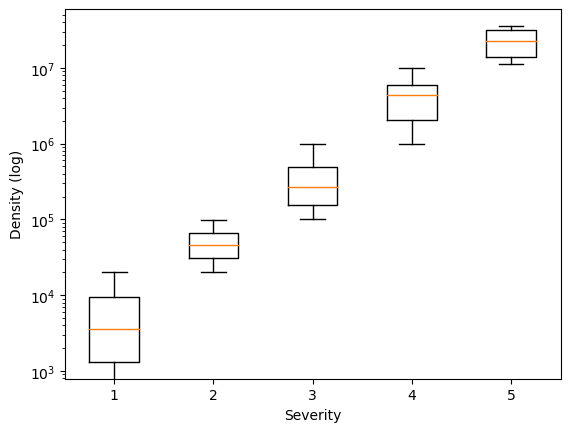

In [77]:
#Figure 7: Range of density values for each severity level
plt.boxplot([train.loc[train['severity']==x,'density'] for x in range(1,6)])
plt.yscale('log')
plt.xticks(rotation=0)
plt.ylabel('Density (log)')
plt.xlabel('Severity')
plt.show();

In [78]:
#density distribution
print("severity over 1,000,000:", np.mean(train['density'] > 1000000))
print("severity over 100,000:", np.mean(train['density'] > 100000))
print("severity over 20,000:", np.mean(train['density'] > 20000))

severity over 1,000,000: 0.21733333333333332
severity over 100,000: 0.41733333333333333
severity over 20,000: 0.6163333333333333


In [79]:
#classifying densities into high/low severities
train['severity_bin'] = np.where(train['density'] >= 20000, 'high', 'low')
train['severity_bin'].value_counts(normalize=True)



high    0.616333
low     0.383667
Name: severity_bin, dtype: float64

In [80]:
#proportion of severity bins with severity levels
train[['severity_bin','severity']].value_counts(normalize=True)

severity_bin  severity
low           1           0.383667
high          4           0.216000
              3           0.200333
              2           0.198667
              5           0.001333
dtype: float64

In [81]:
#covert to latex
train[['severity_bin','severity']].value_counts(normalize=True).reset_index().style.to_latex()

'\\begin{tabular}{llrr}\n & severity_bin & severity & 0 \\\\\n0 & low & 1 & 0.383667 \\\\\n1 & high & 4 & 0.216000 \\\\\n2 & high & 3 & 0.200333 \\\\\n3 & high & 2 & 0.198667 \\\\\n4 & high & 5 & 0.001333 \\\\\n\\end{tabular}\n'

In [82]:
#distribution of severity bins per region
mgd_severity_counts = pd.merge(train[['region', 'severity_bin']].value_counts().reset_index(drop=False).sort_values(['region', 'severity_bin']).rename({0:'count'}, axis=1),
         train['region'].value_counts().reset_index(drop=False).rename({'region':'total', 'index':'region'},axis=1),
         on='region')
mgd_severity_counts['pct'] = mgd_severity_counts['count']/mgd_severity_counts['total']
mgd_severity_counts['pct_total'] = mgd_severity_counts['count']/sum(mgd_severity_counts['total'])
mgd_severity_counts


,region,severity_bin,count,total,pct,pct_total
0,midwest,high,315,387,0.813953,0.052500
1,midwest,low,72,387,0.186047,0.012000
2,northeast,high,116,201,0.577114,0.019333
3,northeast,low,85,201,0.422886,0.014167
4,south,high,762,1749,0.435678,0.127000
5,south,low,987,1749,0.564322,0.164500
6,west,high,656,663,0.989442,0.109333
7,west,low,7,663,0.010558,0.001167


## Downloading Census Data

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import numpy as np
import config

In [85]:
c = Census(config.census_api)
# c = Census(api_key)
states

<module 'us.states' from '/Users/fionachow/opt/anaconda3/envs/bloom/lib/python3.9/site-packages/us/states.py'>

In [86]:
state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

In [87]:
census_dfs = []
for i in state_codes:
    census_dfs.append(c.acs5.state_county_tract(fields = ('NAME', 'B19019_001E', 'B02001_001E', 'B16009_002E', 'B01003_001E', 'B02001_002E', 'B02001_003E',
                                                          'B02001_003E', 'B02001_005E', 'B03001_003E'),
                                      state_fips = state_codes[i],
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2019))

In [88]:
census_df = pd.concat([pd.DataFrame(x) for x in census_dfs], axis=0).rename({'B19019_001E': 'median_household_income',
                                                                             'B02001_001E': 'total_pop_race',
                                                                             'B16009_002E': 'poverty',
                                                                             'B01003_001E': 'total_pop',
                                                                             'B02001_002E': 'white',
                                                                             'B02001_003E': 'black',
                                                                             'B02001_005E': 'asian',
                                                                             'B03001_003E': 'hispanic_latino'
                                                                             }, axis=1)
census_df

,NAME,median_household_income,total_pop_race,poverty,total_pop,white,black,asian,hispanic_latino,state,county,tract
0,"Census Tract 416, Clark County, Washington",37083.0,3486.0,606.0,3486.0,2282.0,351.0,80.0,1033.0,53,011,041600
1,"Census Tract 430, Clark County, Washington",61771.0,1993.0,164.0,1993.0,1706.0,41.0,96.0,444.0,53,011,043000
2,"Census Tract 408.05, Clark County, Washington",98911.0,6981.0,510.0,6981.0,6362.0,48.0,224.0,300.0,53,011,040805
3,"Census Tract 404.03, Clark County, Washington",92546.0,4204.0,292.0,4204.0,3967.0,115.0,63.0,174.0,53,011,040403
4,"Census Tract 406.04, Clark County, Washington",88561.0,5810.0,301.0,5810.0,4852.0,79.0,253.0,651.0,53,011,040604
...,...,...,...,...,...,...,...,...,...,...,...,...
217,"Census Tract 9659, Clay County, South Dakota",32385.0,6131.0,1592.0,6131.0,5223.0,221.0,205.0,239.0,46,027,965900
218,"Census Tract 9543.01, Codington County, South ...",40701.0,4577.0,882.0,4577.0,4226.0,43.0,45.0,71.0,46,029,954301
219,"Census Tract 9543.02, Codington County, South ...",79727.0,5098.0,189.0,5098.0,4914.0,127.0,34.0,34.0,46,029,954302
220,"Census Tract 9545.01, Codington County, South ...",49348.0,2492.0,433.0,2492.0,2243.0,8.0,7.0,130.0,46,029,954501


In [89]:
census_df.shape

(74001, 12)

In [90]:
tract_shape = []
for i in state_codes:
    tract_shape.append(gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_codes[i]}_tract.zip"))

CRSError: Invalid projection: epsg:4269: (Internal Proj Error: proj_create: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

In [41]:
tract_gdf = pd.concat(tract_shape, axis=0).reset_index()
tract_gdf

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,0,53,049,950800,53049950800,9508,Census Tract 9508,G5020,S,42157200,107412602,+46.5827228,-124.0272568,"POLYGON ((-124.08567 46.71716, -124.08256 46.7..."
1,1,53,061,051701,53061051701,517.01,Census Tract 517.01,G5020,S,2491298,0,+47.8299704,-122.2999369,"POLYGON ((-122.31500 47.82142, -122.31498 47.8..."
2,2,53,061,051918,53061051918,519.18,Census Tract 519.18,G5020,S,4477551,0,+47.7834467,-122.2143909,"POLYGON ((-122.23305 47.78378, -122.23304 47.7..."
3,3,53,061,052006,53061052006,520.06,Census Tract 520.06,G5020,S,1932452,0,+47.8494718,-122.1963226,"POLYGON ((-122.20972 47.84538, -122.20963 47.8..."
4,4,53,061,052105,53061052105,521.05,Census Tract 521.05,G5020,S,51597252,3007422,+47.8770813,-122.0961284,"POLYGON ((-122.18909 47.92844, -122.18611 47.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,217,46,081,966301,46081966301,9663.01,Census Tract 9663.01,G5020,S,121953995,301439,+44.5510342,-103.9491554,"POLYGON ((-104.05597 44.56310, -104.05595 44.5..."
73997,218,46,081,966600,46081966600,9666,Census Tract 9666,G5020,S,1080589898,156413,+44.2609032,-103.7870725,"POLYGON ((-104.05563 44.36380, -104.05563 44.3..."
73998,219,46,011,958600,46011958600,9586,Census Tract 9586,G5020,S,933997276,6323802,+44.3767751,-096.5957541,"POLYGON ((-96.75838 44.19721, -96.75739 44.207..."
73999,220,46,011,959000,46011959000,9590,Census Tract 9590,G5020,S,12725733,216908,+44.2768342,-096.7748038,"POLYGON ((-96.78859 44.30193, -96.78858 44.302..."


In [42]:
# create geodataframe
algae_gdf = gpd.GeoDataFrame(
    metadata, geometry=gpd.points_from_xy(metadata['longitude'], metadata['latitude'], crs=4326)).to_crs(4269)
algae_gdf

,uid,latitude,longitude,date,split,geometry
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032)
1,aafp,35.647742,-79.271782,2017-11-15,train,POINT (-79.27178 35.64774)
2,aagm,35.906885,-79.132962,2020-06-10,train,POINT (-79.13296 35.90689)
3,aaia,35.980000,-78.791686,2018-06-27,train,POINT (-78.79169 35.98000)
4,aaql,38.691000,-100.924000,2018-08-13,train,POINT (-100.92400 38.69100)
...,...,...,...,...,...,...
4162,zzkp,42.238550,-111.853100,2017-07-18,test,POINT (-111.85310 42.23855)
4163,zzpz,35.726309,-79.125853,2019-07-17,train,POINT (-79.12585 35.72631)
4164,zzqy,37.928600,-121.561000,2018-05-15,test,POINT (-121.56100 37.92860)
4165,zzry,38.256057,-86.776403,2021-07-19,train,POINT (-86.77640 38.25606)


In [43]:
algae_mgd = algae_gdf.sjoin(tract_gdf, how="left")

In [44]:
# check total missing values (to fix later)
algae_mgd['GEOID'].isna().sum()

42

In [177]:
def calculate_nearest_tract(row, tracts):
    """Calculate distance to nearest tract using the argmin distance"""
    print(row)
    distances = tracts.distance(row)
    return tracts.iloc[np.argmin(distances)]['GEOID']
tract_gdf_proj = tract_gdf.to_crs(3857)
# for those that are missing as a result of the spatial join, calculate GEOID with the smallest (argmin) distance
min_dist_geoid = algae_mgd.to_crs(3857).loc[algae_mgd['GEOID'].isna()]['geometry'].apply(lambda x: calculate_nearest_tract(x, tract_gdf_proj))
min_dist_geoid

POINT (-8803145.331932073 5390947.425112973)
POINT (-8803145.331932073 5390947.425112973)
POINT (-9141185.556080813 5480930.477499096)
POINT (-8833572.622309074 5388900.785383256)
POINT (-8833572.622309074 5388900.785383256)
POINT (-9134877.414496031 5580682.258789208)
POINT (-8833572.622309074 5388900.785383256)
POINT (-8833572.622309074 5388900.785383256)
POINT (-8803145.331932073 5390947.425112973)
POINT (-8803145.331932073 5390947.425112973)
POINT (-9141185.556080813 5480930.477499096)
POINT (-9134877.414496031 5580682.258789208)
POINT (-9134506.386633215 5448435.180076642)
POINT (-8779768.238865487 5437366.610987583)
POINT (-8772161.44410111 5403236.157915665)
POINT (-9141185.556080813 5480930.477499096)
POINT (-9134506.386633215 5448435.180076642)
POINT (-9141185.556080813 5480930.477499096)
POINT (-9134506.386633215 5448435.180076642)
POINT (-9134506.386633215 5448435.180076642)
POINT (-8833572.622309074 5388900.785383256)
POINT (-9134877.414496031 5580682.258789208)
POINT (-877

170     36063990000
232     36063990000
408     26063990000
499     36063990000
502     36063990000
600     26001990000
677     36063990000
1039    36063990000
1558    36063990000
1585    36063990000
1651    26063990000
1666    26001990000
1715    26063990000
1959    36063990000
1976    36063990000
2114    26063990000
2199    26063990000
2273    26063990000
2352    26063990000
2458    26063990000
2484    36063990000
2501    26001990000
2530    36063990000
2734    26063990000
2747    26001990000
2963    36063990000
3061    26063990000
3082    36063990000
3106    36063990000
3153    26001990000
3438    36063990000
3441    36063990000
3475    26001990000
3488    26063990000
3618    36063990000
3750    26063990000
3947    36063990000
Name: geometry, dtype: object

In [178]:
min_dist_geoid.to_csv("./data/min_dist_geoid.csv")

In [179]:
# replace missing values with distances
algae_mgd.loc[algae_mgd['GEOID'].isna(), "GEOID"] = min_dist_geoid

In [180]:
assert algae_mgd["GEOID"].isna().sum() == 0

In [181]:
tract_subset = tract_gdf.loc[tract_gdf["GEOID"].isin(algae_mgd["GEOID"])]
tract_subset.head()

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
180,180,53,031,950202,53031950202,9502.02,Census Tract 9502.02,G5020,S,251348675,80633463,+47.8392523,-122.9122676,"POLYGON ((-123.03756 47.86690, -123.03443 47.8..."
539,539,53,033,023300,53033023300,233,Census Tract 233,G5020,S,3589672,248744,+47.6003452,-122.1289619,"POLYGON ((-122.14288 47.60985, -122.14169 47.6..."
769,769,53,033,032702,53033032702,327.02,Census Tract 327.02,G5020,S,510724443,12498090,+47.4631765,-121.4990586,"POLYGON ((-121.88450 47.50463, -121.88433 47.5..."
941,941,53,045,960300,53045960300,9603,Census Tract 9603,G5020,S,228283084,44758213,+47.4443345,-122.9860811,"POLYGON ((-123.12882 47.37461, -123.12874 47.3..."
1262,1262,53,033,031603,53033031603,316.03,Census Tract 316.03,G5020,S,56005504,1525167,+47.3236554,-121.9918220,"POLYGON ((-122.05462 47.28244, -122.05456 47.2..."


<Axes: >

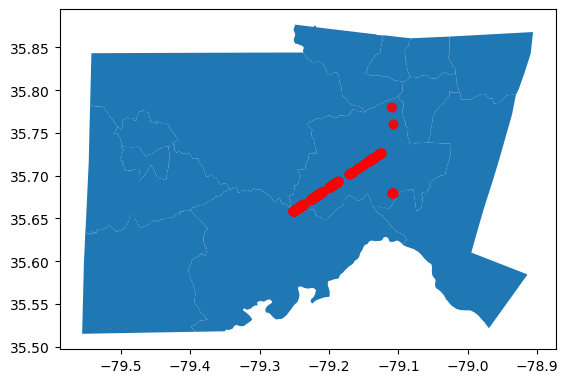

In [45]:
#checking an outlier case
fig, ax = plt.subplots(1, 1)
tract_gdf.loc[(tract_gdf['STATEFP']=='37') & (tract_gdf['COUNTYFP']=='037')].plot(ax=ax)
algae_mgd.loc[algae_mgd['GEOID']=='37037020800'].plot(ax=ax, color='red', alpha=0.5)

In [46]:
# merge to census data
census_df['GEOID'] = census_df['state'] + \
    census_df['county'].str.pad(3, side = 'left', fillchar = '0') + \
    census_df['tract'].str.pad(6, side = 'left', fillchar = '0')
algae_mgd_census = pd.merge(algae_mgd, census_df, on = "GEOID", how = "left")
algae_mgd_census.head()

,uid,latitude,longitude,date,split,geometry,index_right,index,STATEFP,COUNTYFP,...,total_pop_race,poverty,total_pop,white,black,asian,hispanic_latino,state,county,tract
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032),51336.0,923.0,18,105,...,5683.0,319.0,5683.0,5305.0,32.0,31.0,81.0,18,105,001402
1,aafp,35.647742,-79.271782,2017-11-15,train,POINT (-79.27178 35.64774),19434.0,1091.0,37,037,...,5187.0,679.0,5187.0,4117.0,869.0,134.0,303.0,37,037,020600
2,aagm,35.906885,-79.132962,2020-06-10,train,POINT (-79.13296 35.90689),18723.0,380.0,37,135,...,2274.0,184.0,2274.0,1556.0,540.0,16.0,217.0,37,135,010701
3,aaia,35.980000,-78.791686,2018-06-27,train,POINT (-78.79169 35.98000),18997.0,654.0,37,063,...,7416.0,721.0,7416.0,2918.0,3741.0,0.0,738.0,37,063,001806
4,aaql,38.691000,-100.924000,2018-08-13,train,POINT (-100.92400 38.69100),69349.0,327.0,20,171,...,4917.0,274.0,4917.0,4634.0,0.0,61.0,766.0,20,171,957100


In [47]:
algae_mgd_census['poverty_rate'] = algae_mgd_census['poverty'] / algae_mgd_census['total_pop']
algae_mgd_census['percent_white'] = algae_mgd_census['white'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_black'] = algae_mgd_census['black'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_asian'] = algae_mgd_census['asian'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_hispanic_latino'] = algae_mgd_census['hispanic_latino'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_nonwhite'] = (algae_mgd_census['white'] + algae_mgd_census['black'] + algae_mgd_census['asian']) / algae_mgd_census['total_pop_race']

In [48]:
algae_mgd_census.loc[algae_mgd_census['poverty_rate'].isna(), 'total_pop'].isna().sum()

42

In [49]:
# create variable constructs
constructs = ['poverty_rate', 'percent_white', 'percent_black', 'percent_asian', 'percent_hispanic_latino', 'percent_nonwhite']
census_df['poverty_rate'] = census_df['poverty'] / census_df['total_pop']
census_df['percent_white'] = census_df['white'] / census_df['total_pop_race']
census_df['percent_black'] = census_df['black'] / census_df['total_pop_race']
census_df['percent_asian'] = census_df['asian'] / census_df['total_pop_race']
census_df['percent_nonwhite'] = (census_df['white'] + census_df['black'] + census_df['asian']) / census_df['total_pop_race']
census_df['percent_hispanic_latino'] = census_df['hispanic_latino'] / census_df['total_pop_race']

census_state_summ = census_df.groupby('state', as_index = False)[constructs].mean()
census_state_summ.columns = ['state'] + [i + "_state" for i in constructs]
census_state_summ

,state,poverty_rate_state,percent_white_state,percent_black_state,percent_asian_state,percent_hispanic_latino_state,percent_nonwhite_state
0,01,0.168345,0.629139,0.321788,0.011160,0.040617,0.962086
1,02,0.098187,0.628716,0.028743,0.057760,0.063468,0.715220
2,04,0.139709,0.774349,0.042313,0.032215,0.305316,0.848877
3,05,0.159840,0.734703,0.192895,0.012426,0.066940,0.940024
4,06,0.122364,0.604868,0.058291,0.138479,0.380866,0.801637
5,08,0.098256,0.847247,0.037534,0.029517,0.213503,0.914297
6,09,0.095963,0.750618,0.114815,0.042953,0.169997,0.908385
7,10,0.111348,0.691152,0.223111,0.035074,0.092316,0.949338
8,11,0.146126,0.398569,0.485316,0.036713,0.102797,0.920598
9,12,0.130531,0.762284,0.156440,0.024428,0.233372,0.943153


In [50]:
algae_mgd_state = pd.merge(algae_mgd_census, census_state_summ, on = 'state', how = 'left')
# missing values are a population total = 0
algae_mgd_state.head()

,uid,latitude,longitude,date,split,geometry,index_right,index,STATEFP,COUNTYFP,...,percent_black,percent_asian,percent_hispanic_latino,percent_nonwhite,poverty_rate_state,percent_white_state,percent_black_state,percent_asian_state,percent_hispanic_latino_state,percent_nonwhite_state
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032),51336.0,923.0,18,105,...,0.005631,0.005455,0.014253,0.944572,0.135398,0.815416,0.113403,0.018516,0.071056,0.947335
1,aafp,35.647742,-79.271782,2017-11-15,train,POINT (-79.27178 35.64774),19434.0,1091.0,37,037,...,0.167534,0.025834,0.058415,0.987083,0.136625,0.688121,0.217392,0.025458,0.090968,0.930971
2,aagm,35.906885,-79.132962,2020-06-10,train,POINT (-79.13296 35.90689),18723.0,380.0,37,135,...,0.237467,0.007036,0.095427,0.928760,0.136625,0.688121,0.217392,0.025458,0.090968,0.930971
3,aaia,35.980000,-78.791686,2018-06-27,train,POINT (-78.79169 35.98000),18997.0,654.0,37,063,...,0.504450,0.000000,0.099515,0.897923,0.136625,0.688121,0.217392,0.025458,0.090968,0.930971
4,aaql,38.691000,-100.924000,2018-08-13,train,POINT (-100.92400 38.69100),69349.0,327.0,20,171,...,0.000000,0.012406,0.155786,0.954851,0.115239,0.837549,0.066622,0.025983,0.124622,0.930155


In [52]:
# create binary categories
algae_mgd_bin = algae_mgd_state
for i in constructs:
    algae_mgd_bin[i + "_bin"] = np.select([algae_mgd_bin[i] > algae_mgd_bin[i + "_state"],
                                           algae_mgd_bin[i] <= algae_mgd_bin[i + "_state"],
                                            algae_mgd_bin[i].isna()],
                                          [1, 0, 0])
    print(f"\n checking values for {i}")
    print(algae_mgd_bin[i + "_bin"].value_counts(normalize=True).sort_index())
algae_mgd_bin['missing_pop'] = np.where(algae_mgd_bin['total_pop'] == 0 | algae_mgd_bin['total_pop'].isna(), 1, 0)


 checking values for poverty_rate
0    0.803456
1    0.196544
Name: poverty_rate_bin, dtype: float64

 checking values for percent_white
0    0.170146
1    0.829854
Name: percent_white_bin, dtype: float64

 checking values for percent_black
0    0.893928
1    0.106072
Name: percent_black_bin, dtype: float64

 checking values for percent_asian
0    0.841373
1    0.158627
Name: percent_asian_bin, dtype: float64

 checking values for percent_hispanic_latino
0    0.728582
1    0.271418
Name: percent_hispanic_latino_bin, dtype: float64

 checking values for percent_nonwhite
0    0.2539
1    0.7461
Name: percent_nonwhite_bin, dtype: float64


In [53]:
algae_mgd_bin.to_csv("./data/algae_pts_with_tracts.csv")

## Code for hyperparameter tuning
* Note: most of this code is copied from the original [GitHub repository](https://github.com/apwheele/algaebloom), as we downsample the data.

In [53]:
from src import feat, mod
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime

today = feat.today_str()

In [56]:
#added main_prepdata.py which generates the database 
import pandas as pd
import sqlite3

db = './data/data.sqlite'
tab_names = ['elevation_dem','split_pred','spat_lag','sat']
meta_names = ['meta','labels', 'format']
meta_csv = ['metadata','train_labels','submission_format']

fd = {c:t for c,t in zip(meta_csv,meta_names)}
ft = {t:t for t in tab_names}
fd.update(ft)

# Function to save out csv files
def save_csv(db=db):
    db_con = sqlite3.connect(db)
    for t in tab_names:
        res = pd.read_sql(f'SELECT * FROM {t}',db_con)
        res.to_csv(f'./data/{t}.csv',index=False)

# Function to prep SQLite DB
def prep_sql(db=db):
    db_con = sqlite3.connect(db)
    for csv,tab_name in fd.items():
        res = pd.read_csv(f'./data/{csv}.csv')
        res.to_sql(tab_name,index=False,if_exists='replace',con=db_con)
    # Showing resulting table names
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    rt = pd.read_sql(query,db_con)
    print('Resulting table names in sqlite')
    print(rt['name'].tolist())

if __name__ == "__main__":
    print('Executing script to prep data in sqlite')
    print('This expects the csv files listed at front')
    print('of script to be in the data folder')
    prep_sql()


Executing script to prep data in sqlite
This expects the csv files listed at front
of script to be in the data folder
Resulting table names in sqlite
['meta', 'labels', 'format', 'elevation_dem', 'split_pred', 'spat_lag', 'sat']


### Tuning
* Sub-sampling 3,000 rows from the original training dataset, filtered for year > 2016
* Using 500 rows as the test dataset
* All code comes from the original repository with slight modifications

In [6]:
import optuna
from src import feat, mod

res_results = {}

train_dat = feat.get_data(split_pred=True)
print(train_dat.shape)

c:\Users\Jennah\anaconda3\envs\bloom\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(3000, 38)


In [7]:
# need to add for testing purposes
print(test.shape)
#feat.add_table(test, 'test_labels', db)

(1167, 4)


In [8]:
# Model fit with weights
weight_cats = tuple([False])

# Model fit with categorical variables
cat_cats = (True,False)

# Lat/Lon included in model
xy_cats = {'no': [],
           'both': ['latitude','longitude'],
           'lat': ['latitude'],
           'lon': ['longitude']}

xy_keys = tuple(xy_cats.keys())

# Region variables
region_cats = {'both': ['region','cluster'],
               'reg':  ['region'],
               'clust':  ['cluster']}

reg_keys = tuple(region_cats.keys())

# Elevation Variables
ele_cats = {'max_dif':['maxe','dife'],
            'all_var':['maxe','dife','elevation','stde'],
            'ele_std':['elevation','stde'],
            'ele_dif':['elevation','dife'],
            'max_std':['maxe','stde'] }

ele_keys = tuple(ele_cats.keys())

In [10]:
# Spatial Lag Variables
sl_cats = {#'lag100': ['severity_100','logDensity_100','count_100'],
           #'lag300': ['severity_300','logDensity_300','count_300'],
           #'lag1000': ['severity_1000','logDensity_1000','count_1000'],
           'lagNone': []}

sl_keys = tuple(sl_cats.keys())

# Sat imagery data
sat_cats = {'sat500': ['imtype','prop_lake_500','r_500','g_500','b_500'],
            'sat1000': ['imtype','prop_lake_1000','r_1000','g_1000','b_1000'],
            'sat2500': ['imtype','prop_lake_2500','r_2500','g_2500','b_2500'],
            'sat500_1000': ['imtype','prop_lake_500','r_500','g_500','b_500', 'prop_lake_1000','r_1000','g_1000','b_1000'],
            'sat500_2500': ['imtype','prop_lake_500','r_500','g_500','b_500', 'prop_lake_2500','r_2500','g_2500','b_2500'],
            'sat1000_2500': ['imtype','prop_lake_1000','r_1000','g_1000','b_1000', 'prop_lake_2500','r_2500','g_2500','b_2500']}

sat_keys = tuple(sat_cats.keys())


In [12]:
def objective_lgb(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "ele_set": trial.suggest_categorical("ele_vars", ele_keys),
        "xy_set": trial.suggest_categorical("xy_set", xy_keys),
        "sl_set": trial.suggest_categorical("sl_set", sl_keys),
        "reg_set": trial.suggest_categorical("reg_set", reg_keys),
        "weight": trial.suggest_categorical("weight", weight_cats),
        "cat_type": trial.suggest_categorical("cat_type", cat_cats),
        "sat_set": trial.suggest_categorical("sat_set", sat_keys),
    }
    # Setting the different variables
    ov = region_cats[param['reg_set']]
    #if 'imtype' in sat_cats[param['sat_set']]:
    #    ov.append('imtype')
    cv = ele_cats[param['ele_set']] + xy_cats[param['xy_set']]
    cv += sl_cats[param['sl_set']]
    cv += sat_cats[param['sat_set']]
    rm = mod.RegMod(ord_vars=ov,
                    dum_vars=None,
                    dat_vars=['date'],
                    ide_vars=cv,
                    weight = 'split_pred',
                    y='severity',
                    mod = mod.LGBMRegressor(n_estimators=round(param['n_estimators']),
                                            max_depth=param['max_depth']))
    avg_rmse = rm.met_eval(train_dat,ret=True,weight=param['weight'],cat=param['cat_type'])
    return avg_rmse

study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=300) # 150
trial_lgb = study_lgb.best_trial
res_results['lgb'] = trial_lgb

[I 2023-04-24 15:33:16,915] A new study created in memory with name: no-name-bfaf5b1c-ac29-41b7-a6de-78bc61afb225
[I 2023-04-24 15:33:17,975] Trial 0 finished with value: 0.8307540464005815 and parameters: {'n_estimators': 130, 'max_depth': 7, 'ele_vars': 'max_std', 'xy_set': 'lat', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': False, 'sat_set': 'sat500_2500'}. Best is trial 0 with value: 0.8307540464005815.
[I 2023-04-24 15:33:23,184] Trial 1 finished with value: 0.8801454449119639 and parameters: {'n_estimators': 360, 'max_depth': 10, 'ele_vars': 'max_dif', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': True, 'sat_set': 'sat500_2500'}. Best is trial 0 with value: 0.8307540464005815.
[I 2023-04-24 15:33:23,951] Trial 2 finished with value: 0.9701927798346872 and parameters: {'n_estimators': 30, 'max_depth': 2, 'ele_vars': 'ele_dif', 'xy_set': 'no', 'sl_set': 'lagNone', 'reg_set': 'clust', 'weight': False, 'cat_type': False,

In [11]:
def objective_xgb(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "ele_set": trial.suggest_categorical("ele_vars", ele_keys),
        "xy_set": trial.suggest_categorical("xy_set", xy_keys),
        "sl_set": trial.suggest_categorical("sl_set", sl_keys),
        "reg_set": trial.suggest_categorical("reg_set", reg_keys),
        "weight": trial.suggest_categorical("weight", weight_cats),
        "sat_set": trial.suggest_categorical("sat_set", sat_keys),
    }
    # Setting the different variables
    ov = region_cats[param['reg_set']]
    #if 'imtype' in sat_cats[param['sat_set']]:
    #    ov.append('imtype')
    cv = ele_cats[param['ele_set']] + xy_cats[param['xy_set']]
    cv += sl_cats[param['sl_set']]
    cv += sat_cats[param['sat_set']]
    rm = mod.RegMod(ord_vars=ov,
                    dum_vars=None,
                    dat_vars=['date'],
                    ide_vars=cv,
                    weight = 'split_pred',
                    y='severity',
                    mod = mod.XGBRegressor(n_estimators=round(param['n_estimators']),
                                           max_depth=param['max_depth'])
                )
    avg_rmse = rm.met_eval(train_dat,ret=True,weight=param['weight'])
    return avg_rmse

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=300)
trial_xgb = study_xgb.best_trial
res_results['xgb'] = trial_xgb

[I 2023-04-25 14:40:58,745] A new study created in memory with name: no-name-79c529d0-2632-4738-aed1-d35a0e6b042e
[I 2023-04-25 14:41:04,497] Trial 0 finished with value: 0.9402009655943425 and parameters: {'n_estimators': 410, 'max_depth': 5, 'ele_vars': 'max_dif', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'sat_set': 'sat500_1000'}. Best is trial 0 with value: 0.9402009655943425.
[I 2023-04-25 14:41:06,218] Trial 1 finished with value: 0.884089008922398 and parameters: {'n_estimators': 60, 'max_depth': 6, 'ele_vars': 'max_dif', 'xy_set': 'lat', 'sl_set': 'lagNone', 'reg_set': 'reg', 'weight': False, 'sat_set': 'sat2500'}. Best is trial 1 with value: 0.884089008922398.
[I 2023-04-25 14:41:14,053] Trial 2 finished with value: 0.9496008659978219 and parameters: {'n_estimators': 560, 'max_depth': 4, 'ele_vars': 'ele_dif', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'sat_set': 'sat1000_2500'}. Best is trial 1 with value: 0.88408

In [9]:
def objective_cat(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "ele_set": trial.suggest_categorical("ele_vars", ele_keys),
        "xy_set": trial.suggest_categorical("xy_set", xy_keys),
        "sl_set": trial.suggest_categorical("sl_set", sl_keys),
        "reg_set": trial.suggest_categorical("reg_set", reg_keys),
        "weight": trial.suggest_categorical("weight", weight_cats),
        "cat_type": trial.suggest_categorical("cat_type", cat_cats),
        "sat_set": trial.suggest_categorical("sat_set", sat_keys),
    }
    # Setting the different variables
    ov = region_cats[param['reg_set']]
    #if 'imtype' in sat_cats[param['sat_set']]:
    #    ov.append('imtype')
    cv = ele_cats[param['ele_set']] + xy_cats[param['xy_set']]
    cv += sl_cats[param['sl_set']]
    cv += sat_cats[param['sat_set']]
    rm = mod.RegMod(ord_vars=ov,
                    dum_vars=None,
                    dat_vars=['date'],
                    ide_vars=cv,
                    weight = 'split_pred',
                    y='severity',
                    mod = mod.CatBoostRegressor(iterations=round(param['n_estimators']),
                                                depth=param['max_depth'],
                                                allow_writing_files=False,
                                                verbose=False)
                )
    # print(train_dat.shape)
    avg_rmse = rm.met_eval(train_dat,ret=True, weight=param['weight'],cat=param['cat_type'])
    return avg_rmse

study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=300, n_jobs=-1)
trial_cat = study_cat.best_trial
res_results['cat'] = trial_cat

[I 2023-04-21 23:53:31,907] A new study created in memory with name: no-name-dca3a0fe-8826-478f-9fe9-ae22cb802f37
[I 2023-04-21 23:53:34,463] Trial 2 finished with value: 0.8875163968633825 and parameters: {'n_estimators': 140, 'max_depth': 2, 'ele_vars': 'all_var', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': True, 'sat_set': 'sat1000_2500'}. Best is trial 2 with value: 0.8875163968633825.
[I 2023-04-21 23:53:36,296] Trial 6 finished with value: 0.9108613125253899 and parameters: {'n_estimators': 310, 'max_depth': 3, 'ele_vars': 'max_std', 'xy_set': 'lat', 'sl_set': 'lagNone', 'reg_set': 'reg', 'weight': False, 'cat_type': True, 'sat_set': 'sat1000'}. Best is trial 2 with value: 0.8875163968633825.
[I 2023-04-21 23:53:36,868] Trial 0 finished with value: 0.8231002921406869 and parameters: {'n_estimators': 510, 'max_depth': 3, 'ele_vars': 'max_std', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': False, 'sat

In [13]:
print(f"Best Average RMSE LightBoost {trial_lgb.value}")
print("Best Params")
print(trial_lgb.params)

Best Average RMSE LightBoost 0.7889932873562553
Best Params
{'n_estimators': 30, 'max_depth': 4, 'ele_vars': 'max_std', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'reg', 'weight': False, 'cat_type': True, 'sat_set': 'sat500'}


In [12]:
print(f"Best Average RMSE XGBoost {trial_xgb.value}")
print("Best Params")
print(trial_xgb.params)

Best Average RMSE XGBoost 0.8361939088152124
Best Params
{'n_estimators': 270, 'max_depth': 9, 'ele_vars': 'ele_std', 'xy_set': 'both', 'sl_set': 'lagNone', 'reg_set': 'clust', 'weight': False, 'sat_set': 'sat1000'}


In [11]:
print(f"Best Average RMSE CatBoost {trial_cat.value}")
print("Best Params")
print(trial_cat.params)

Best Average RMSE CatBoost 0.8015699072381228
Best Params
{'n_estimators': 420, 'max_depth': 3, 'ele_vars': 'ele_std', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': False, 'sat_set': 'sat500_2500'}


In [57]:
#main_preds.py

from src import feat, mod

today = feat.today_str()
train_dat = feat.get_data(split_pred=True)
print(train_dat.shape)
###################################
# Example just predicting severity directly

sat_500 = ['prop_lake_500', 'r_500', 'g_500', 'b_500']
sat_1000 = ['prop_lake_1000', 'r_1000', 'g_1000', 'b_1000']
sat_2500 = ['prop_lake_2500', 'r_2500', 'g_2500', 'b_2500']
sat_1025 = ['prop_lake_2500', 'r_2500', 'g_2500', 'b_2500', 
           'prop_lake_1000', 'r_1000', 'g_1000', 'b_1000']

cat = mod.RegMod(ord_vars=region_cats['both'],
                dat_vars=['date'],
                ide_vars=ele_cats['ele_std'] + xy_cats['lon'] + sl_cats['lagNone'] + sat_cats['sat500_2500'],
                y='severity',
                mod = mod.CatBoostRegressor(iterations=420,depth=3,
                   allow_writing_files=False,verbose=False)
                )
cat.fit(train_dat,weight=False,cat=False)


lig = mod.RegMod(ord_vars=region_cats['both'],
                dat_vars=['date'],
                ide_vars=ele_cats['max_std'] + xy_cats['lon'] + sl_cats['lagNone'] + sat_cats['sat500'],
                y='severity',
                mod = mod.LGBMRegressor(n_estimators=30, 
                                        max_depth=4))
lig.fit(train_dat,weight=False,cat=True)


xgb = mod.RegMod(ord_vars=region_cats['clust'],
                 dat_vars=['date'],
                 ide_vars=ele_cats['ele_std'] + xy_cats['both'] + sl_cats['lagNone'] + sat_1000,
                 y='severity',
                 mod = mod.XGBRegressor(n_estimators=270, max_depth=9))
xgb.fit(train_dat,weight=False,cat=False)


rm = mod.EnsMod(mods={'xgb': xgb, 'cat': cat, 'lig': lig})

(3000, 38)


NameError: name 'region_cats' is not defined

In [55]:
# Now getting files for out of sample data
test = feat.get_data(data_type='test')
print("Rows in test data:", test.shape[0])
test['pred'] = rm.predict_int(test)

form_dat = test.copy()
form_dat['severity'] = form_dat['pred'].round().astype(int).clip(1,5)
print(test['severity'].value_counts())
print(test['pred'].value_counts())

DatabaseError: Execution failed on sql '
SELECT 
  m.uid,
  l.density,
  l.region,
  l.severity,
  m.latitude,
  m.longitude,
  m.date,
  e.elevation,
  e.mine,
  e.maxe,
  e.dife,
  e.avge,
  e.stde,
  sl.severity_100,
  sl.logDensity_100,
  sl.count_100,
  sl.severity_300,
  sl.logDensity_300,
  sl.count_300,
  sl.severity_1000,
  sl.logDensity_1000,
  sl.count_1000,
  st.imtype,
  st.prop_lake_500,
  st.r_500,
  st.g_500,
  st.b_500,
  st.prop_lake_1000,
  st.r_1000,
  st.g_1000,
  st.b_1000,
  st.prop_lake_2500,
  st.r_2500,
  st.g_2500,
  st.b_2500
FROM meta AS m
LEFT JOIN elevation_dem AS e
  ON m.uid = e.uid
LEFT JOIN spat_lag AS sl
  ON m.uid = sl.uid
LEFT JOIN sat AS st
  ON m.uid = st.uid
LEFT JOIN test_labels AS l
  ON m.uid = l.uid
WHERE
  m.split = 'test'
': no such table: test_labels

In [16]:
# function to check if similar to any past submissions
mod.check_similar(form_dat)

# Checking to see differences compared to best submission so far
current = form_dat.copy()
mod.check_day(current,day="sub_2023_02_16.csv")
current.groupby('region',as_index=False)['dif_2023_02_16'].value_counts()

# Saving the data and model
form_dat.to_csv(f'sub_BESTRESULTS_0216.csv',index=False)
mod.save_model(rm,f'mod_BESTRESULTS_0216')

 0.0    329
-1.0    201
 1.0    181
 2.0    171
-2.0    150
 3.0     82
-3.0     53
Name: dif_2023_02_16, dtype: int64


## Evaluating performance and fairness

In [50]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [51]:
test['severity_bin'] = np.where(test['density'] >= 20000, 1, 0)
test['pred_bin'] = np.where(test['pred'] >= 2, 1, 0)
print(test['severity_bin'].value_counts(normalize=True))
print(test['pred_bin'].value_counts(normalize=True))

print("\nAccuracy:", accuracy_score(test['severity_bin'], test['pred_bin']))
print("Recall:", recall_score(test['severity_bin'], test['pred_bin']))
print("Precision:", precision_score(test['severity_bin'], test['pred_bin']))

KeyError: 'pred'

In [49]:
# look at confusion matrix
tn, fp, fn, tp = confusion_matrix(test['severity_bin'], test['pred_bin']).ravel()
print("TN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

NameError: name 'confusion_matrix' is not defined

In [20]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics as skm

from fairlearn.datasets import fetch_adult
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (selection_rate, demographic_parity_difference, demographic_parity_ratio, 
                               selection_rate_difference, false_negative_rate_difference, 
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

import sklearn.metrics as skm


from IPython.display import clear_output

In [47]:
# load census data
algae_mgd_census = pd.read_csv("./data/algae_pts_with_tracts.csv")
print(algae_mgd_census.columns)
test_census = pd.merge(test, algae_mgd_census, how = 'left', on = 'uid')
test_census = test_census.loc[test_census['poverty_rate_bin'] != -9]
test_census.head()

Index(['Unnamed: 0', 'uid', 'latitude', 'longitude', 'date', 'split',
       'geometry', 'index_right', 'index', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON'],
      dtype='object')


,uid,region,severity,density,Unnamed: 0,latitude,longitude,date,split,geometry,...,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,aarq,northeast,1,10133.000000,28,39.902930,-75.180150,2017-12-05,train,POINT (-75.18015 39.90293),...,37300.0,42101037300,373.0,Census Tract 373,G5020,S,2587546.0,145214.0,39.902498,-75.187936
1,abjj,northeast,2,55049.333333,52,42.056766,-78.879216,2019-09-24,train,POINT (-78.879216 42.056766),...,961300.0,36009961300,9613.0,Census Tract 9613,G5020,S,413393836.0,2880671.0,42.060184,-78.674417
2,abrn,northeast,1,7626.284722,62,41.890646,-78.925275,2017-10-05,train,POINT (-78.925275 41.890646),...,970100.0,42123970100,9701.0,Census Tract 9701,G5020,S,310664149.0,25274451.0,41.927987,-78.965633
3,actk,northeast,1,1267.000000,99,41.894240,-78.938750,2019-04-16,train,POINT (-78.93875 41.89424),...,970100.0,42123970100,9701.0,Census Tract 9701,G5020,S,310664149.0,25274451.0,41.927987,-78.965633
4,adxo,northeast,1,5300.663072,138,41.841242,-78.994719,2020-09-02,train,POINT (-78.994719 41.841242),...,971000.0,42123971000,9710.0,Census Tract 9710,G5020,S,93286921.0,2119392.0,41.865242,-79.063685


In [48]:
test_census[['percent_asian','percent_asian_state']]

KeyError: "None of [Index(['percent_asian', 'percent_asian_state'], dtype='object')] are in the [columns]"

In [22]:
test_census['poverty_rate_bin'].value_counts()

0    1004
1     163
Name: poverty_rate_bin, dtype: int64

In [23]:
test_census['poverty_rate_bin'].isna().sum()

0

In [24]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['poverty_rate_bin'])
demo_parity_ratio = demographic_parity_ratio(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['poverty_rate_bin'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

Demographic parity difference: 0.0699
Demographic parity ratio: 0.9180


In [25]:
#compute selection rate for low and high poverty
high_selection_rate = selection_rate(test_census['severity_bin'][test_census['poverty_rate_bin']==1], test_census['pred_bin'][test_census['poverty_rate_bin']==1])
low_selection_rate = selection_rate(test_census['severity_bin'][test_census['poverty_rate_bin']==0], test_census['pred_bin'][test_census['poverty_rate_bin']==0])

print(f'high selection rate: {high_selection_rate:.4f}')
print(f'low selection rate: {low_selection_rate:.4f}')

high selection rate: 0.8528
low selection rate: 0.7829


In [26]:
def generate_sample_params(sensitive_feat):
  return ({'accuracy': None,
                      'precision': None,
                      'recall': None,
                      'FNR': None,
                      'FPR': None,
                      'FNR_diff': {'sensitive_features' : sensitive_feat},
                      'FPR_diff': {'sensitive_features' : sensitive_feat},
                      'demo_parity_ratio': {'sensitive_features' : sensitive_feat},
                      'equalized_odds_ratio': {'sensitive_features' : sensitive_feat},
                      'sel_rate_diff': {'sensitive_features' : sensitive_feat},})

In [27]:
def generate_metrics(df, sensitive_feature):
    sensitive_feature = df[sensitive_feature].replace({0:'low', 1:'high'})

    #evaluation metrics
    metrics = {'accuracy': skm.accuracy_score,
            'precision': skm.precision_score,
            'recall': skm.recall_score,
            'FNR': false_negative_rate,
            'FPR': false_positive_rate,
            'FNR_diff': false_negative_rate_difference,
            'FPR_diff': false_positive_rate_difference,
            'demo_parity_ratio': demographic_parity_ratio,
            'equalized_odds_ratio': equalized_odds_ratio,
            'sel_rate_diff': selection_rate_difference,
            }

    sample_params_dict = generate_sample_params(sensitive_feature)
    grouped_on_pov = MetricFrame(metrics=metrics,
                                y_true=df['severity_bin'],
                                y_pred=df['pred_bin'],
                                sensitive_features=sensitive_feature,
                                sample_params= sample_params_dict)
    print(grouped_on_pov.overall.to_frame())

    print(grouped_on_pov.by_group)
generate_metrics(test_census, 'poverty_rate_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.008059
FPR_diff              0.044680
demo_parity_ratio     0.918040
equalized_odds_ratio  0.913618
sel_rate_diff         0.069892
                  accuracy  precision    recall       FNR       FPR  FNR_diff  \
poverty_rate_bin                                                                
high              0.846626   0.892086  0.925373  0.074627  0.517241       0.0   
low               0.800797   0.802799  0.933432  0.066568  0.472561       0.0   

                  FPR_diff  demo_parity_ratio  equalized_odds_ratio  \
poverty_rate_bin                                                      
high                   0.0                1.0                   1.0   
low                    0.0                1.0                   1.0   

                  sel_rate_diff  
poverty_rate_bi

In [28]:
generate_metrics(test_census, 'percent_white_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.046592
FPR_diff              0.266331
demo_parity_ratio     0.699210
equalized_odds_ratio  0.526087
sel_rate_diff         0.253162
                   accuracy  precision    recall       FNR       FPR  \
percent_white_bin                                                      
high               0.809777   0.828283  0.938484  0.061516  0.561983   
low                0.796460   0.744361  0.891892  0.108108  0.295652   

                   FNR_diff  FPR_diff  demo_parity_ratio  \
percent_white_bin                                          
high                    0.0       0.0                1.0   
low                     0.0       0.0                1.0   

                   equalized_odds_ratio  sel_rate_diff  
percent_white_bin                                       
high           

In [29]:
generate_metrics(test_census, 'percent_nonwhite_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.030932
FPR_diff              0.263355
demo_parity_ratio     0.749913
equalized_odds_ratio  0.531814
sel_rate_diff         0.209733
                      accuracy  precision    recall       FNR       FPR  \
percent_nonwhite_bin                                                      
high                  0.805708   0.823298  0.937407  0.062593  0.562500   
low                   0.812500   0.782609  0.906475  0.093525  0.299145   

                      FNR_diff  FPR_diff  demo_parity_ratio  \
percent_nonwhite_bin                                          
high                       0.0       0.0                1.0   
low                        0.0       0.0                1.0   

                      equalized_odds_ratio  sel_rate_diff  
percent_nonwhite_bin                         